# BooksNN - Automatic feature labeling and scrolling through plots on click

The idea here is to put the different conventional classification methods together and display everything on one plot to do a sanity check for whether they're doing a good job.

* H/M/L seasonality based on both up MSE between series and ideal (to identify H), as well as std/mean (to identify M)
* popular/unpopular based on salesrank average from year. 
* high/low stock (based on MSE of uc)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyisbn #module for converting ISBN-13 to ISBN-10 and vice versa
import booksnn as bnn

from sklearn.metrics import mean_squared_error


## Load data - average trends
Either load from database, or load average trends from csv. 
Warning: If reading from database, this could take some time. 500 ASINs already takes several minutes. 

In [2]:
## LOAD single year ideal trends from csv
#Based on averaging
up_year = pd.read_csv('./stats/up_year.csv',index_col='index')
uc_year = pd.read_csv('./stats/uc_year.csv',index_col='index')
sr_year = pd.read_csv('./stats/sr_year.csv',index_col='index')

#Based on statsmodels
up_year_sm = pd.read_csv('./stats/up_year_sm.csv',index_col='index')
uc_year_sm = pd.read_csv('./stats/uc_year_sm.csv',index_col='index')
sr_year_sm = pd.read_csv('./stats/sr_year_sm.csv',index_col='index')

In [5]:
## LOAD ALL SERIES FROM DB
asins_in_db = bnn.get_asin_list()
print('Total number of ASINs in database: ' + str(len(asins_in_db)))
asins = asins_in_db[0:100] #select a subset if desired
print('Total number of ASINs selected: ' + str(len(asins))+'\n')


# Check if mean price and salesrank in last year was high/low enough. If not, move products to 
# a second database for rejects. 

startdate = '2016-01-01'
enddate = '2020-12-08'
up = bnn.dicts_to_dataframe(bnn.get_usedprice(asins),startdate,enddate)
uc = bnn.dicts_to_dataframe(bnn.get_usedcount(asins),startdate,enddate)
sr = bnn.dicts_to_dataframe(bnn.get_salesrank(asins),startdate,enddate)

#take the log of salesrank
sr = np.log(sr)

Total number of ASINs in database: 577
Total number of ASINs selected: 100



<ipython-input-5-efaa0a1fe96c>:18: RuntimeWarning: invalid value encountered in log
  sr = np.log(sr)


In [3]:
def add_labels_to_plot(fig,ax1,ax2,ax3,title_text='ASIN'):
    fig.suptitle(title_text, fontsize=16)
    ax1.grid()
    ax1.set_title('Used price')
    ax1.set_xlabel('date')
    ax1.set_ylabel('$')

    ax2.grid()
    ax2.set_title('Used count')
    ax2.set_xlabel('date')
    ax2.set_ylabel('#')

    ax3.grid()
    ax3.set_title('Salesrank')
    ax3.set_xlabel('date')
    ax3.set_ylabel('')
    return

<IPython.core.display.Javascript object>


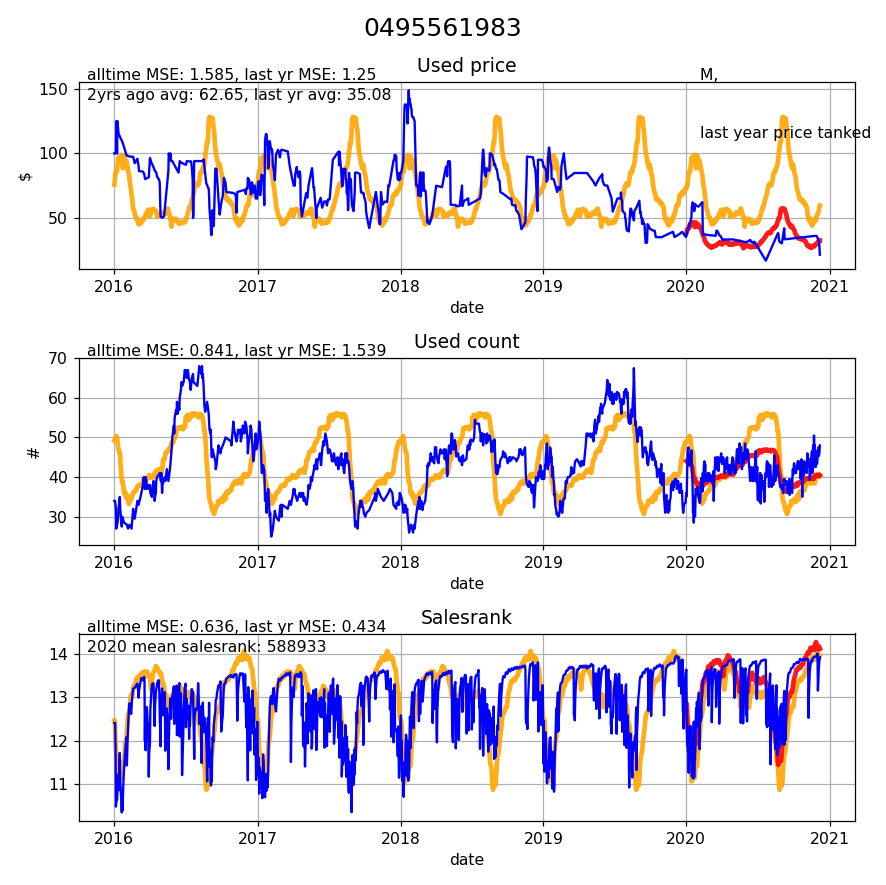

In [20]:
%matplotlib notebook

#WORKING! 

class figBuilder:
    def __init__(self, fig,ax1,ax2,ax3):
        # Must pass in figure that already has right size
        self.fig = fig
        self.ax1 = ax1 
        self.ax2 = ax2 
        self.ax3 = ax3 

        self.i = 0
        self.asin = list(up.columns)[self.i]
        self.ax1.text(0,0, 'initial text, i='+str(self.i), va="bottom", ha="left")
        self.ax2.text(0,0, 'initial text, i='+str(self.i), va="bottom", ha="left")
        self.ax3.text(0,0, 'initial text, i='+str(self.i), va="bottom", ha="left")

        self.cid = self.fig.canvas.mpl_connect('scroll_event', self)

    def __call__(self, event):
        if event.button == 'up':
            self.i += 1
        else: 
            self.i -= 1
        
        if self.i < 0:
            self.i = 0
        if self.i > len(up.columns):
            self.i = len(up.columns)
        self.asin = list(up.columns)[self.i]
        
        self.fig.suptitle(self.asin, fontsize=16)
        
        self.ax1.clear() #clear axes
        self.ax2.clear()
        self.ax3.clear()
        
        lastyear = 2020
        
        #First, scale series for plotting
        # Used price
        up_ideal_scaled = (up_year_sm*np.std(up[self.asin]))+np.mean(up[self.asin])
        up_ideal_scaled = bnn.rep_partial_years(up_ideal_scaled,up[self.asin])
        up_lastyear = up[self.asin][up.index.year==lastyear]
        up_ideal_lastyear_scaled = (up_year_sm*np.std(up_lastyear))+np.mean(up_lastyear)
        up_ideal_lastyear_scaled = bnn.rep_partial_years(up_ideal_lastyear_scaled,up_lastyear)
        
        # Used count
        uc_ideal_scaled = (uc_year_sm*np.std(uc[self.asin]))+np.mean(uc[self.asin])
        uc_ideal_scaled = bnn.rep_partial_years(uc_ideal_scaled,uc[self.asin]) #change inde
        uc_lastyear = uc[self.asin][uc.index.year==lastyear]
        uc_ideal_lastyear_scaled = (uc_year_sm*np.std(uc_lastyear))+np.mean(uc_lastyear)
        uc_ideal_lastyear_scaled = bnn.rep_partial_years(uc_ideal_lastyear_scaled,uc_lastyear)
        
        # Sales rank
        sr_ideal_scaled = (sr_year_sm*np.std(sr[self.asin]))+np.mean(sr[self.asin])
        sr_ideal_scaled = bnn.rep_partial_years(sr_ideal_scaled,sr[self.asin]) #change inde
        sr_lastyear = sr[self.asin][sr.index.year==lastyear]
        sr_ideal_lastyear_scaled = (sr_year_sm*np.std(sr_lastyear))+np.mean(sr_lastyear)
        sr_ideal_lastyear_scaled = bnn.rep_partial_years(sr_ideal_lastyear_scaled,sr_lastyear)

        # Plotting
        self.ax1.plot(up_ideal_scaled,linewidth=3,alpha=.9,c='orange')
        self.ax1.plot(up_ideal_lastyear_scaled,linewidth=3,alpha=.9,c='red')
        self.ax1.plot(up[self.asin],c='blue')        

        self.ax2.plot(uc_ideal_scaled,linewidth=3,alpha=.9,c='orange')
        self.ax2.plot(uc_ideal_lastyear_scaled,linewidth=3,alpha=.9,c='red')
        self.ax2.plot(uc[self.asin],c='blue')

        self.ax3.plot(sr_ideal_scaled,linewidth=3,alpha=.9,c='orange')
        self.ax3.plot(sr_ideal_lastyear_scaled,linewidth=3,alpha=.9,c='red')
        self.ax3.plot(sr[self.asin],c='blue')
        
        add_labels_to_plot(self.fig,self.ax1,self.ax2,self.ax3,self.asin)
        
        # Get classifications
        (classifications, stats) = trend_classifier((up_year_sm,uc_year_sm,sr_year_sm),
                                                            (up[self.asin],uc[self.asin],sr[self.asin]))
        
        # Annotate stats
        self.ax1.annotate('alltime MSE: '+str(stats['up_mse_alltime'])+', last yr MSE: '+str(stats['up_mse_lastyear']),
                          xy=(0.01, 1.01), xycoords='axes fraction')
        self.ax1.annotate('2yrs ago avg: '+str(stats['up_mean_twoyearsago'])+', last yr avg: '+str(stats['up_mean_lastyear']),
                          xy=(0.01, .9), xycoords='axes fraction')
        self.ax2.annotate('alltime MSE: '+str(stats['uc_mse_alltime'])+', last yr MSE: '+str(stats['uc_mse_lastyear']),
                          xy=(0.01, 1.01), xycoords='axes fraction')
        self.ax3.annotate('alltime MSE: '+str(stats['sr_mse_alltime'])+', last yr MSE: '+str(stats['sr_mse_lastyear']),
                          xy=(0.01, 1.01), xycoords='axes fraction')
        self.ax3.annotate('2020 mean salesrank: '+str(stats['sr_mean_lastyear']),
                          xy=(0.01, 0.9), xycoords='axes fraction')
        
        # Annotate classifications
        self.ax1.annotate(classifications['seasonality']+', '+classifications['seasonality_notes'],
                          xy=(.8, 1.01), xycoords='axes fraction')
        self.ax1.annotate(classifications['price_swings'],xy=(0.8,0.9), xycoords='axes fraction')
        self.ax1.annotate(classifications['price_magnitude'],xy=(0.8,0.8), xycoords='axes fraction')
        self.ax1.annotate(classifications['price_avg_trend'],xy=(0.8,0.7), xycoords='axes fraction')
        self.ax1.annotate(classifications['popularity'],xy=(0.8,0.6), xycoords='axes fraction')
        

fig = plt.figure(figsize = (7,7),tight_layout=True)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
add_labels_to_plot(fig,ax1,ax2,ax3)
plt.tight_layout()

axbuilder = figBuilder(fig,ax1,ax2,ax3)

plt.show()

In [11]:
def trend_classifier(ideal_yearly_normalized,data): 
    (up_ideal,uc_ideal,sr_ideal) = ideal_yearly_normalized
    (up,uc,sr) = data
    classifications = {'seasonality': '' ,           #(H/M/L), 
                       'seasonality_notes':'',       # favorite, formerly seasonal, 
                       'price_swings':'',            # 'big price swings',
                       'price_magnitude': '',        # 'too low', 'high value'
                       'price_avg_trend':'',         # ('price tanked', 'avg price inc','too cheap to be worthwhile'),
                       'popularity': '',             # (popular, unpopular, extremely_unpopular),
                       #'used_count': ''              # ('lower than avg competition','higher than avg competition')
                      }
    # CHANGE YEARS AS TIME GOES ON!
    lastyear = 2020
    twoyearsago = 2019
    
    # Calculate stats
    up_mse_alltime = round(mean_squared_error(bnn.rep_partial_years(up_ideal,up),
                                (up-np.mean(up))/np.std(up)),3)
    up_mse_lastyear = round(mean_squared_error(bnn.rep_partial_years(up_ideal,up[up.index.year==lastyear]),
                        (up[up.index.year==lastyear]-np.mean(up[up.index.year==lastyear]))/np.std(up[up.index.year==lastyear])),3)
    up_mean_twoyearsago = round(np.mean(up[up.index.year==twoyearsago]),2)
    up_mean_lastyear = round(np.mean(up[up.index.year==lastyear]),2)
    up_std_over_mean_lastyear = round(np.std(up[up.index.year==lastyear])/up_mean_lastyear,3)
    
    uc_mse_alltime = round(mean_squared_error(bnn.rep_partial_years(uc_ideal,uc),
                                (uc-np.mean(uc))/np.std(uc)),3)
    uc_mse_lastyear = round(mean_squared_error(bnn.rep_partial_years(uc_ideal,uc[uc.index.year==2020]),
                        (uc[uc.index.year==2020]-np.mean(uc[uc.index.year==2020]))/np.std(uc[uc.index.year==2020])),3)
    
    sr_mse_alltime = round(mean_squared_error(bnn.rep_partial_years(sr_ideal,sr),
                                (sr-np.mean(sr))/np.std(sr)),3)
    sr_mse_lastyear = round(mean_squared_error(bnn.rep_partial_years(sr_ideal,sr[sr.index.year==2020]),
                        (sr[sr.index.year==2020]-np.mean(sr[sr.index.year==2020]))/np.std(sr[sr.index.year==2020])),3)
    
    # Seasonality and seasonality notes
    if up_mse_alltime < 1.2:
        classifications['seasonality'] = 'H'
        if up_mse_lastyear < 1.1:
             classifications['seasonality_notes'] = 'favorite'
    elif up_mse_alltime < 1.6:
        classifications['seasonality'] = 'M'
        if up_mse_lastyear > 2:
             classifications['seasonality_notes'] = 'formerly seasonal'
    else: 
        classifications['seasonality'] = 'L'

    # Price variation, regardless of season
    if up_std_over_mean_lastyear > .3:
        classifications['price_swings'] = 'big price swings'
    elif up_std_over_mean_lastyear < .2:
        classifications['price_swings'] = 'small price swings'
    
    if np.mean(up[up.index.year==lastyear]) + np.std(up[up.index.year==lastyear]) < 25:
        classifications['price_magnitude'] = 'too cheap'
    elif np.mean(up[up.index.year==lastyear])+np.std(up[up.index.year==lastyear]) > 150:
        classifications['price_magnitude'] = 'high value'

    if np.mean(up[up.index.year==lastyear]) < np.mean(up[up.index.year==twoyearsago]*.75):
        classifications['price_avg_trend'] = 'last year price tanked'
    elif np.mean(up[up.index.year==lastyear]) > np.mean(up[up.index.year==twoyearsago]*1.4):
        classifications['price_avg_trend'] = 'price increasing'
    
    sr_mean_lastyear = int(np.exp(np.mean(sr[sr.index.year==lastyear])))
    if sr_mean_lastyear > 1200000:
        classifications['popularity'] = 'way too unpopular'
    elif sr_mean_lastyear > 800000:
        popularity = 'unpopular'
    elif sr_mean_lastyear < 20000:
        classifications['popularity'] = 'very popular'
    
    stats = {'up_mse_alltime': up_mse_alltime,
             'up_mse_lastyear': up_mse_lastyear,
             'up_mean_twoyearsago': up_mean_twoyearsago,
             'up_mean_lastyear': up_mean_lastyear,
             'up_std_over_mean_lastyear': up_std_over_mean_lastyear,
             'uc_mse_alltime': uc_mse_alltime,
             'uc_mse_lastyear': uc_mse_lastyear,
             'sr_mse_alltime': sr_mse_alltime,
             'sr_mse_lastyear': sr_mse_lastyear,
             'sr_mean_lastyear': sr_mean_lastyear
            }

    return classifications, stats